In [249]:
# Let's import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score
# pd.set_option('display.max_columns', None)

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Data verification
- verifying if all the columns has data

### Observation
- Many columns has null values

In [250]:
surpriseHousingData = pd.read_csv("train.csv")
print(surpriseHousingData.info())
surpriseHousingData.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

(1460, 81)

### Analysing NA values
1. According to the data dictionary, an NA value signifies that the item is missing or not present, rather than indicating the absence of a value.
2. It is necessary to isolate columns containing numerical data and substitute NA values with zeros.
3. In columns that contain categorical data, NA values should be replaced with the term "notavail".


In [251]:
# Extracting numberic columns and replace NA with zero
surpriseHousingNumDf = surpriseHousingData.select_dtypes(include=['float64', 'int64'])
surpriseHousingNumCols=list(surpriseHousingNumDf.columns)
surpriseHousingData[surpriseHousingNumCols]=surpriseHousingData[surpriseHousingNumCols].fillna(0)
print('Numeric columns count ',len(surpriseHousingNumCols))
print('Numeric columns \n',surpriseHousingData[surpriseHousingNumCols].isna().sum(),'\n\n\n')


# Extract catagorical columns and replace NA with notavail
surpriseHousingCatDf=surpriseHousingData.select_dtypes(include=['object'])
surpriseHousingCatCols=list(surpriseHousingCatDf.columns)
surpriseHousingData[surpriseHousingCatCols]=surpriseHousingData[surpriseHousingCatCols].fillna('notavail')
print('categorical columns count ',len(surpriseHousingCatCols))
print('categorical columns \n',surpriseHousingData[surpriseHousingCatCols].isna().sum())


Numeric columns count  38
Numeric columns 
 Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64 



categorical columns count  43
categorical columns 
 MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood 

### Examining the columns, we will eliminate those with a variance below 10%.
1. Our goal is to assess the distribution of data within each column. We observe that several columns predominantly consist of a single value, accounting for 90% of the entries. Such columns are likely ineffective in predicting the target variable due to the lack of diversity in their values.
2. Columns where a single value represents more than 90% of the data, indicating a variance of less than 10%, will be eliminated from our analysis.

In [252]:
colLen=len(surpriseHousingData.columns)
surpriseHousingDataColLst=list(surpriseHousingData.columns)
column_10Percent_variance =[]
for i in range(colLen):
    if any(surpriseHousingData[surpriseHousingDataColLst[i]].astype('category').value_counts(normalize=True) > 0.90):
        print('\n',surpriseHousingData[surpriseHousingDataColLst[i]].astype('category').value_counts(normalize=True)*100,'\n\n')
        column_10Percent_variance.append(surpriseHousingDataColLst[i])
print(column_10Percent_variance) 


 Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64 



 notavail    93.767123
Grvl         3.424658
Pave         2.808219
Name: Alley, dtype: float64 



 AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64 



 Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64 



 Norm      98.972603
Feedr      0.410959
Artery     0.136986
PosN       0.136986
RRNn       0.136986
PosA       0.068493
RRAe       0.068493
RRAn       0.068493
Name: Condition2, dtype: float64 



 CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
ClyTile     0.068493
Membran     0.068493
Metal       0.068493
Roll        0.068493
Name: RoofMatl, dtype: float64 



 GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
OthW      0.136986
Floor     0.068493
Name: Heating, dtype: float64 



 Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64 



 SBrkr       91.369863
FuseA        6.438356
F

21


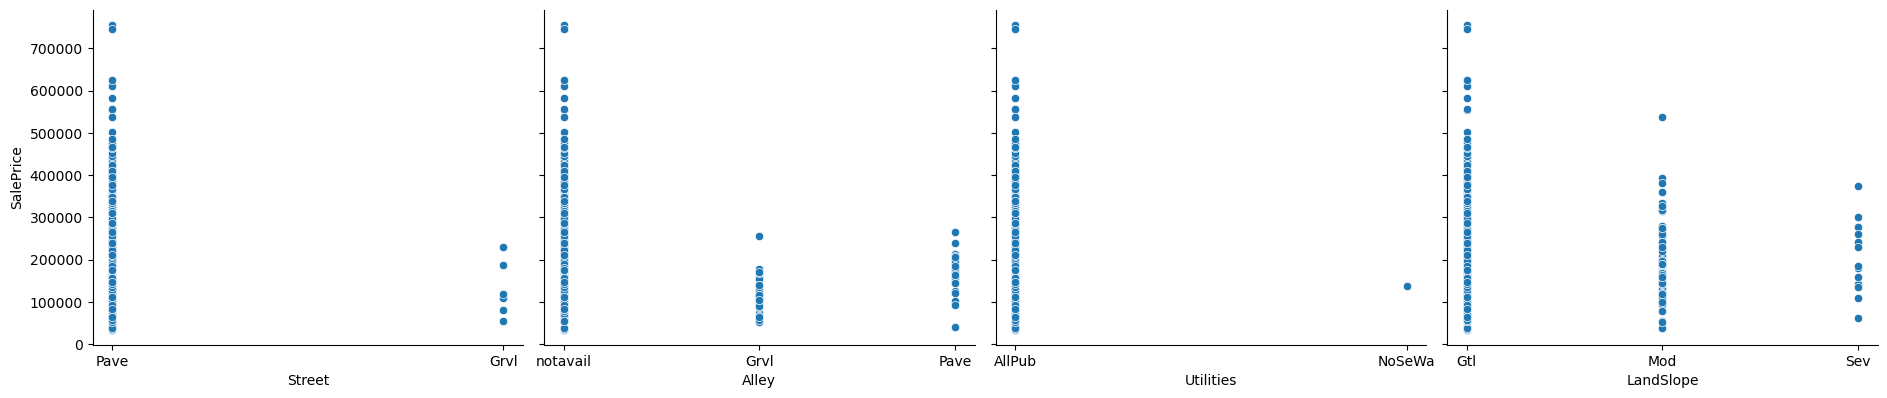

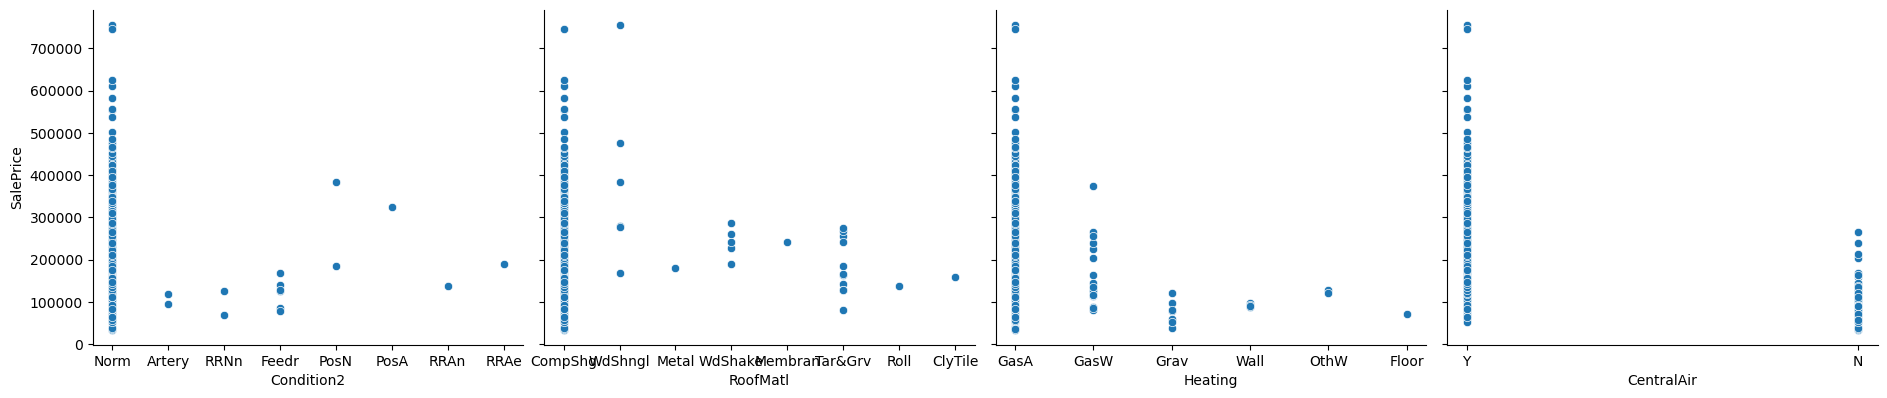

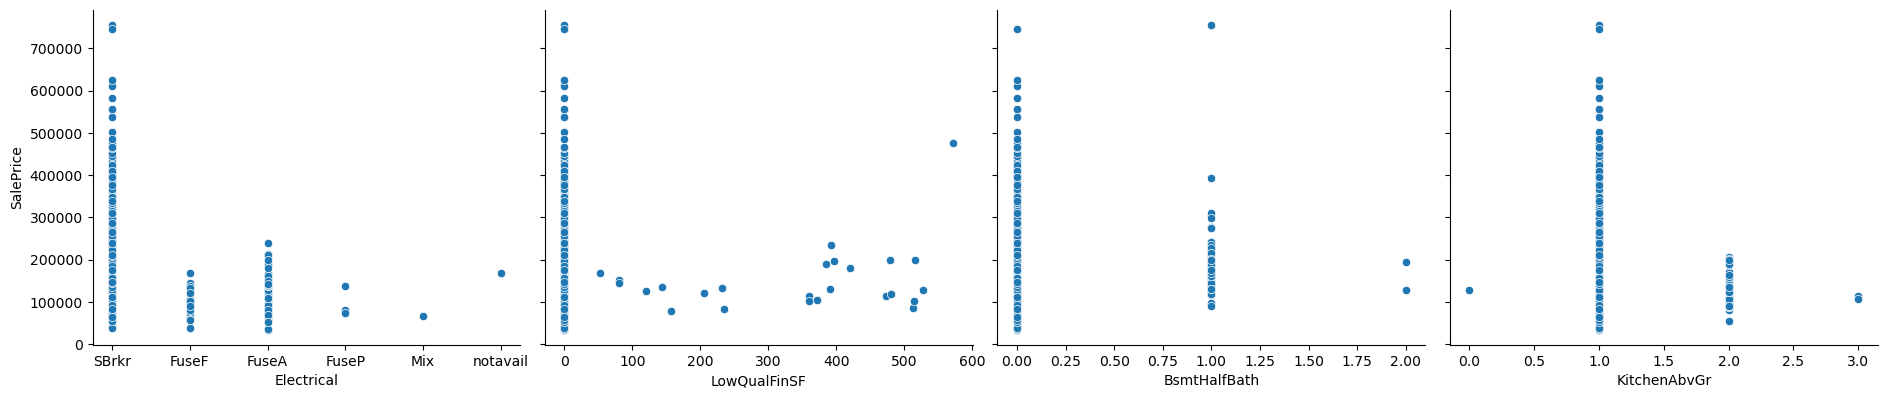

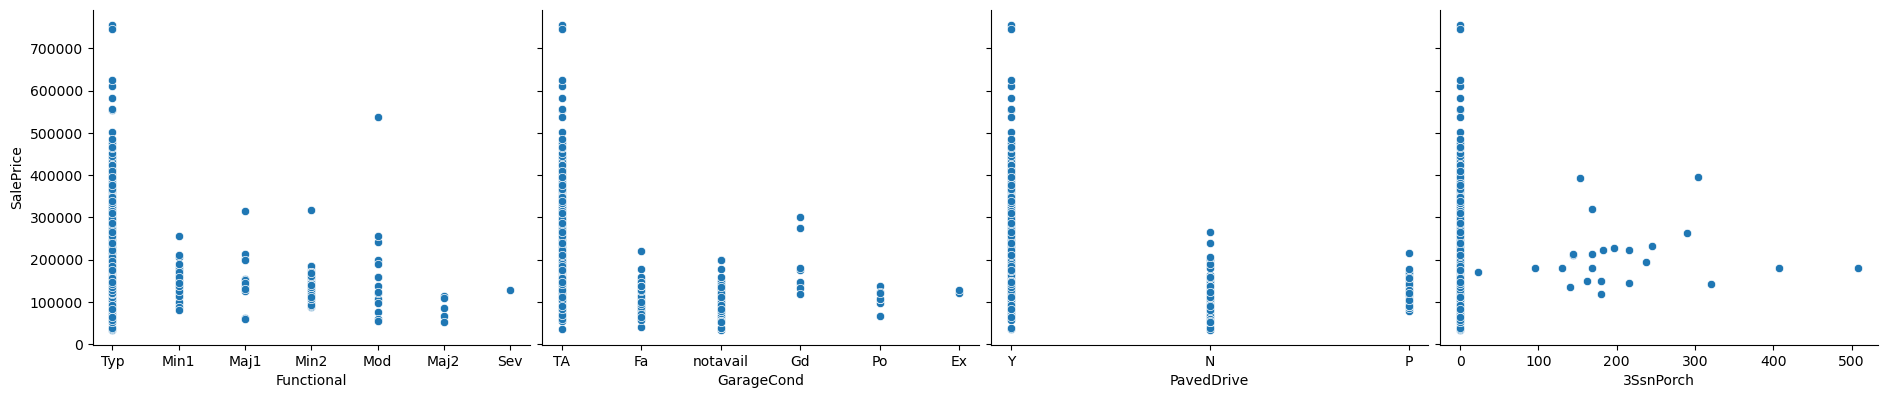

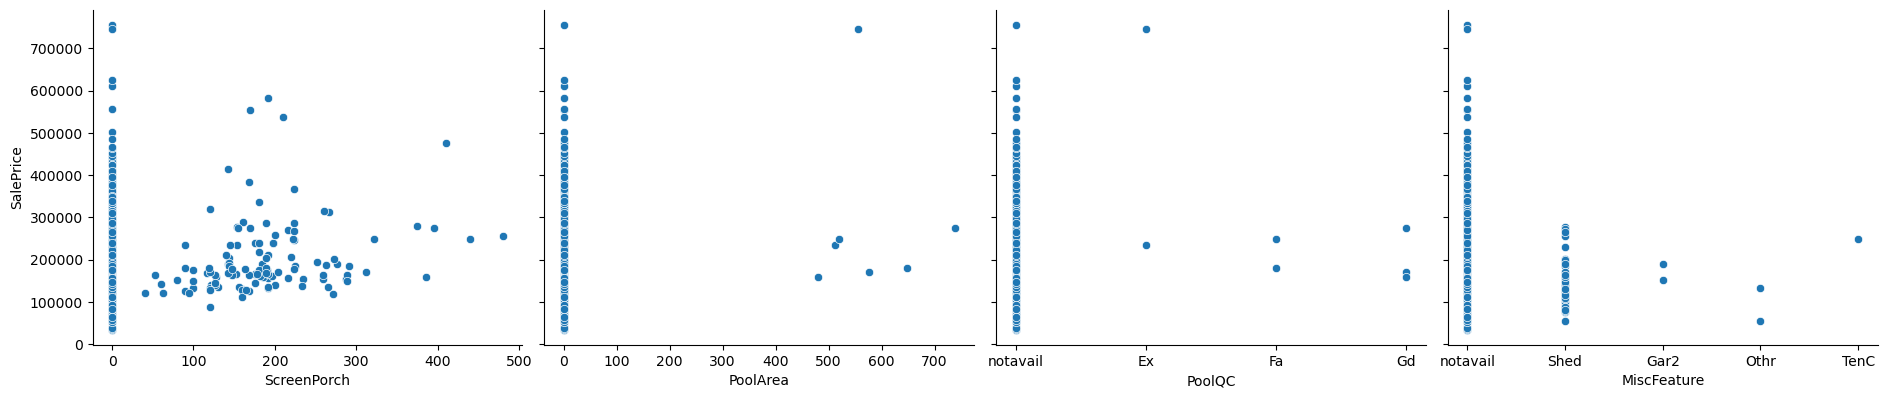

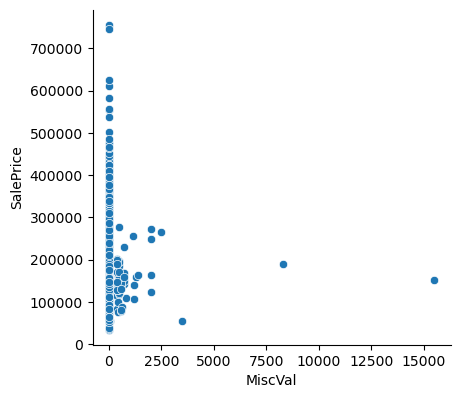

In [253]:
xcols= []
colLstLen=len(column_10Percent_variance)
print(colLstLen)
for i in range(0,colLstLen,4):
    if(i+4>colLstLen-1):
        if(i<=colLstLen-1):
            xcols.append(column_10Percent_variance[i])
        if(i+1<=colLstLen-1):
            xcols.append(column_10Percent_variance[i+1])
        if(i+2<=colLstLen-1):
            xcols.append(column_10Percent_variance[i+2])
        if(i+3<=colLstLen-1):
            xcols.append(column_10Percent_variance[i+3])
        sns.pairplot(data=surpriseHousingData, y_vars='SalePrice', x_vars=xcols,height=4, aspect=1.2)
    else:
        xcols.append(column_10Percent_variance[i])
        xcols.append(column_10Percent_variance[i+1])
        xcols.append(column_10Percent_variance[i+2])
        xcols.append(column_10Percent_variance[i+3])
        sns.pairplot(data=surpriseHousingData, y_vars='SalePrice', x_vars=xcols,height=4, aspect=1.2)
    xcols.clear()

plt.show()


### Above pairplot shows columns having less variance against target variable. 
--- as these columns have less variance they hold less predictive power, so we can remove these columns

## Removing columns where more than 90% of the data is the same (not much variety).

In [254]:
surpriseHousingData.drop(column_10Percent_variance, axis=1,inplace=True)
surpriseHousingData.shape

(1460, 60)

##### ID column as it has no predictive power so remove it

In [255]:
surpriseHousingData.drop(columns=['Id'],inplace=True)
surpriseHousingData.shape

(1460, 59)

<Axes: xlabel='SalePrice', ylabel='Density'>

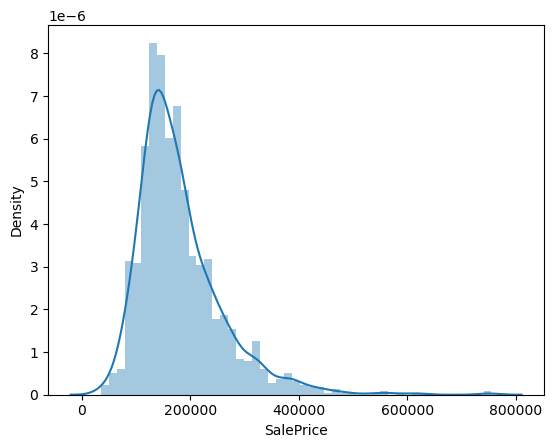

In [256]:
sns.distplot(surpriseHousingData['SalePrice'])

### Distplot of the target variable SalesPrice shows that values are trailing towards right end of trail
- Using logarithmic transformation to address data skewness.

<Axes: xlabel='SalePrice', ylabel='Density'>

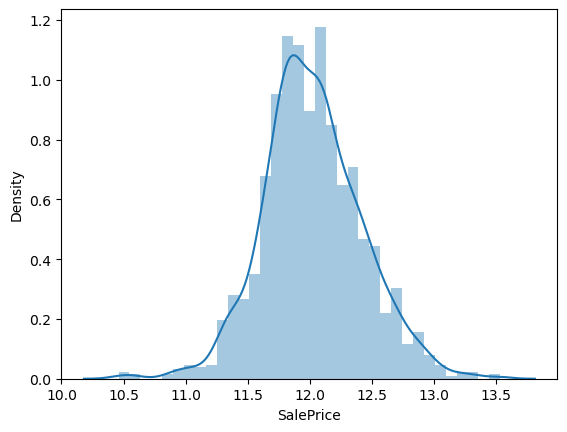

In [257]:
surpriseHousingData['SalePrice']=np.log1p(surpriseHousingData['SalePrice'])
sns.distplot(surpriseHousingData['SalePrice'])

### Analysing if independent variables has linear relationship with target variable (SalesPrice)
1. The heat map indicates a linear connection between numerous independent variables and the target variable (sales price).
2. Typically, heat maps are generated to illustrate relationships among numerical variables.
3. Several independent variables are linearly correlated, leading to multicollinearity. However, we won't eliminate these columns because multicollinearity is automatically managed in Ridge and Lasso regression methods.

(1460, 59)


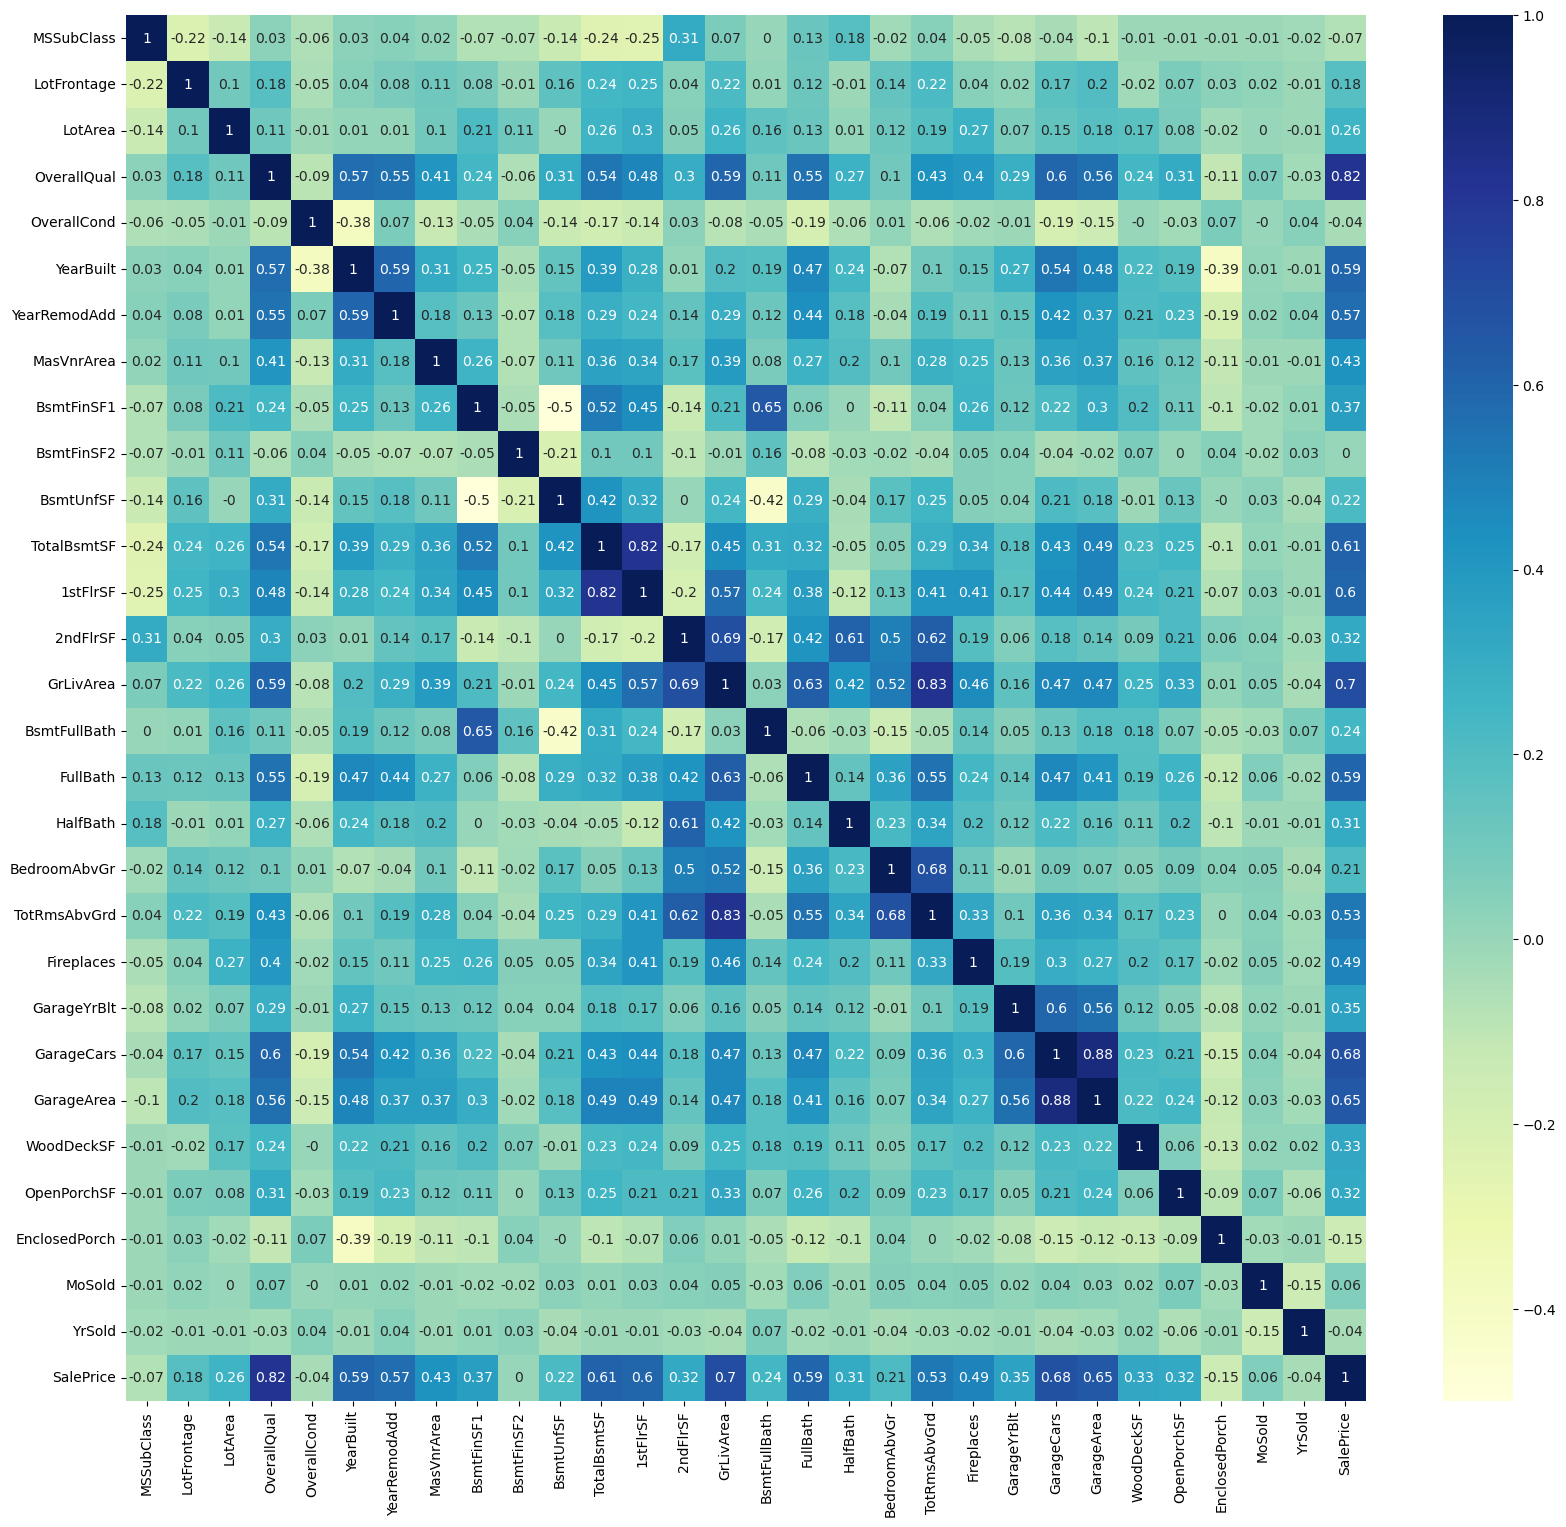

In [258]:
print(surpriseHousingData.shape)
cor=surpriseHousingData.corr()
plt.figure(figsize=(20,18))

# heatmap of surpriseHousingData
sns.heatmap(round(cor,2), cmap="YlGnBu", annot=True)
plt.show()

In [259]:
surpriseHousingData.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,6.321918,2007.815753,12.024057
std,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,2.703626,1.328095,0.399449
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775105
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,6.000000,2008.000000,12.001512
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,8.000000,2009.000000,12.273736
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,12.000000,2010.000000,13.534474


### Creating dummies for categorical columns

In [260]:

catColumns=list(surpriseHousingData.select_dtypes(include=['object']).columns)
print(catColumns,'\n\n')

dummiesDf=pd.get_dummies(surpriseHousingData[catColumns],drop_first=True)
print('Housing data before concatinating dummies',surpriseHousingData.shape)

surpriseHousingData=pd.concat([surpriseHousingData,dummiesDf],axis=1)
print('Housing data after concatinating dummies',surpriseHousingData.shape)

# keeping only dummies and removing original columns
surpriseHousingData=surpriseHousingData.drop(columns=catColumns)
print('Housing data after dropping dummies orginal colmns',surpriseHousingData.shape)

surpriseHousingData

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'Fence', 'SaleType', 'SaleCondition'] 


Housing data before concatinating dummies (1460, 59)
Housing data after concatinating dummies (1460, 233)
Housing data after dropping dummies orginal colmns (1460, 204)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,0,1,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,0,1,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,0,1,0,0,0,1,0


### Spliting Data into test and train

In [261]:
train_surpriseHousingData, test_surpriseHousingData=train_test_split(surpriseHousingData,train_size=.7, 
                                                               test_size = 0.3,random_state=100)
print('train surpriseHousingData ',train_surpriseHousingData.shape)
print('test surpriseHousingData ',test_surpriseHousingData.shape)

train surpriseHousingData  (1021, 204)
test surpriseHousingData  (438, 204)


## Scaling Train Data

In [262]:
train_surpriseHousingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 210 to 79
Columns: 204 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(4), int64(26), uint8(174)
memory usage: 420.8 KB


##### Numeric columns has data type as float and int while dummy columns has data type of uint hence we can use float and int to scale . We need not scale dummy columns

In [263]:
numericColLst =list(train_surpriseHousingData.select_dtypes(include=['float64','int64']).columns)
print(numericColLst)
scaler =MinMaxScaler()
train_surpriseHousingData[numericColLst]=scaler.fit_transform(train_surpriseHousingData[numericColLst])
train_surpriseHousingData.head()

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SalePrice']


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.058824,0.214058,0.019306,0.444444,0.625,0.384058,0.000000,0.00,0.082920,0.0,...,0,0,0,0,1,0,0,0,1,0
318,0.235294,0.287540,0.039403,0.666667,0.500,0.876812,0.716667,0.16,0.174876,0.0,...,0,0,0,0,1,0,0,0,1,0
239,0.176471,0.166134,0.033981,0.555556,0.375,0.528986,0.000000,0.00,0.016655,0.0,...,0,0,0,0,1,0,0,0,1,0
986,0.176471,0.188498,0.017931,0.555556,0.875,0.275362,0.883333,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
1416,1.000000,0.191693,0.046139,0.333333,0.625,0.094203,0.000000,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0


## Scaling Test Data

In [264]:
test_surpriseHousingData[numericColLst]=scaler.transform(test_surpriseHousingData[numericColLst])
test_surpriseHousingData.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,0.000000,0.191693,0.035192,0.333333,0.625,0.717391,0.350000,0.00000,0.109142,0.0,...,0,0,0,0,1,0,0,0,1,0
57,0.235294,0.284345,0.047566,0.666667,0.500,0.956522,0.900000,0.00000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
780,0.000000,0.201278,0.029930,0.666667,0.500,0.891304,0.766667,0.02375,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
382,0.235294,0.252396,0.036338,0.666667,0.500,0.971014,0.933333,0.00000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
1170,0.352941,0.242812,0.039309,0.555556,0.625,0.760870,0.450000,0.00000,0.092488,0.0,...,0,0,0,0,1,0,0,0,1,0


## Extracting x and y test train data

In [265]:
# extract target variable and independent variable from train
y_train=train_surpriseHousingData.pop('SalePrice')
x_train=train_surpriseHousingData
# extract target variable and independent variable from test
y_test=test_surpriseHousingData.pop('SalePrice')
x_test=test_surpriseHousingData

## Linear Regression model

In [266]:
linearRegression=LinearRegression()
linearRegression.fit(x_train,y_train)
rfe=RFE(linearRegression, n_features_to_select=90)
rfe=rfe.fit(x_train,y_train)

featuresRanking=list(zip(x_train.columns,rfe.support_,rfe.ranking_))

rfeColsList=list(x_train.columns[rfe.support_])

print('RFE selected column: \n',x_train.columns[rfe.support_])
print('\n')
print('RFE not Selected column: \n',x_train.columns[~rfe.support_])


RFE selected column: 
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'WoodDeckSF',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR3', 'LandContour_Low', 'LandContour_Lvl',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_SWISU', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm',
       'Condition1_PosN', 'BldgType_Duplex', 'BldgType_Twnhs',
       'HouseStyle_2.5Unf', 'RoofStyle_Mansard', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior2nd_Asp

In [267]:
linearRegressionModel = LinearRegression()

# fit a line 
linearRegressionModel.fit(x_train[rfeColsList], y_train)

print('linearRegressionModel intercept βo \n',round(linearRegressionModel.intercept_,3))
print('\nlinearRegressionModel β coefficents \n',linearRegressionModel.coef_)


linearRegressionModel intercept βo 
 0.047

linearRegressionModel β coefficents 
 [-3.85850195e-02 -2.79321479e-02  1.14102684e-01  1.45776939e-01
  9.92559749e-02  1.08197961e-01  2.43863332e-02 -4.77982788e+11
 -1.24831082e+11 -1.97832706e+11  5.17447702e+11  1.92045212e-01
  7.46002197e-02  1.60676003e-01  6.21309280e-02  2.06336975e-02
  4.46014404e-02  1.92985535e-02  8.14304352e-02  2.86474228e-02
  1.07788086e-01  1.33514404e-01  1.25915527e-01  1.10000610e-01
 -3.58734131e-02  2.45285034e-02  1.81536674e-02 -1.82991028e-02
  3.24664116e-02  6.17269278e-02 -2.81906128e-02 -3.85131836e-02
  3.91159058e-02  3.31039429e-02  2.18391418e-02  4.56199646e-02
  5.36499023e-02  2.23178864e-02  1.76925659e-02 -1.62353516e-02
 -1.93328857e-02 -2.28271484e-02  1.51519775e-02  1.95903778e-02
 -3.75146408e+09 -3.94554138e-02  3.84025574e-02 -4.32255648e+09
  3.75146408e+09  4.32255648e+09  4.36002346e+09 -1.91001892e-02
  2.39105225e-02  1.95007324e-02  1.74713135e-02  1.26533508e-02
 -9.0465

In [268]:
y_pred_train = linearRegressionModel.predict(x_train[rfeColsList])
y_pred_test = linearRegressionModel.predict(x_test[rfeColsList])

r2ScoreTrain_lr = r2_score(y_train, y_pred_train)
r2ScoreTest_lr = r2_score(y_test, y_pred_test)

rssTrain_lr=np.sum(np.square(y_train-y_pred_train))
rssTest_lr=np.sum(np.square(y_test-y_pred_test))

mseTrain_lr = mean_squared_error(y_train, y_pred_train)
rmseTrain_lr=mseTrain_lr**.5


mseTest_lr = mean_squared_error(y_test, y_pred_test)
rmseTest_lr=mseTest_lr**.5

linearRegressionData = {
    'Linear Regression':{'R2_score Train': r2ScoreTrain_lr, 'R2_score Test': r2ScoreTest_lr, 'RSS Train': rssTrain_lr,
     'RSS Test': rssTest_lr, 'MSE Train': mseTrain_lr, 'MSE Test': mseTest_lr,'RMSE Train': rmseTrain_lr,
                        'RMSE Test': rmseTest_lr}
}

modelPerformanceComparision = pd.DataFrame.from_dict(linearRegressionData)
modelPerformanceComparision

vif=pd.DataFrame()
vifColLst=x_train[rfeColsList].columns
vif['Features']=vifColLst
vif['VIF']=[variance_inflation_factor(x_train[rfeColsList].values,i) for i in range(x_train[rfeColsList].shape[1])]
vif['VIF']=round(vif['VIF'],2)
print('VIF \n',vif.sort_values(by='VIF',ascending=False))
modelPerformanceComparision


VIF 
                  Features   VIF
44    Exterior1st_AsphShn   inf
47     Exterior1st_CBlock   inf
84           SaleType_New   inf
80    GarageQual_notavail   inf
78  GarageFinish_notavail   inf
..                    ...   ...
75         FireplaceQu_Po  1.11
82           SaleType_Con  1.10
71           HeatingQC_Po  1.03
50      Exterior2nd_Other   NaN
58           ExterCond_Po   NaN

[90 rows x 2 columns]


,Linear Regression
MSE Test,3.324731e+20
MSE Train,1.451160e-03
R2_score Test,-1.909659e+22
R2_score Train,9.127515e-01
RMSE Test,1.823385e+10
RMSE Train,3.809409e-02
RSS Test,1.456232e+23
RSS Train,1.481634e+00


## Infinite VIF shows that multicollinearity is not handled by Linear Regression

## Interpretation of Linear Regression model

1. The model excels with the training data but significantly underperforms with the test data, suggesting overfitting. This occurs when the model excessively memorizes the training data, including its irregularities, thus failing to predict new data accurately. The R2 score for the training set is very high and drops significantly in test, at 0.91, pointing to overfitting and indicating that the model cannot be effectively applied to data beyond the training set.

2. A negative R² score for the test set signals that the model's predictions are substantially inferior to just using the average of the target values, highlighting the model's inadequacy in making accurate predictions for unseen data.

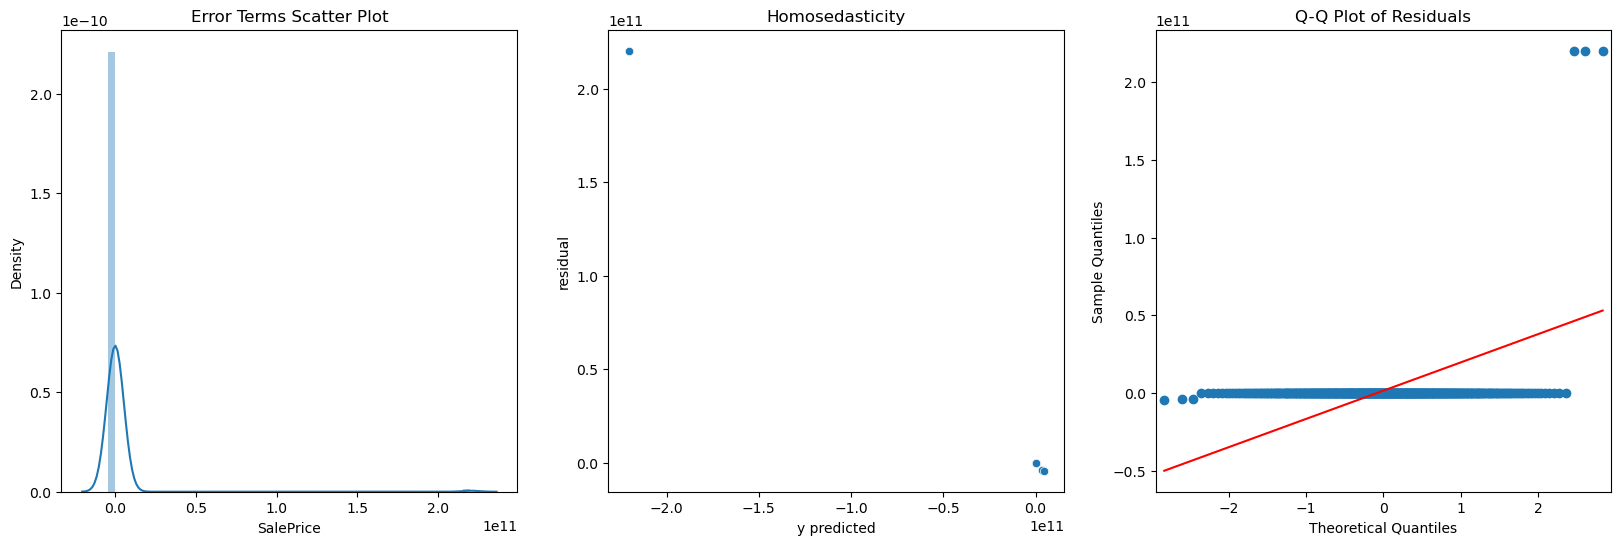

In [269]:
# Verifying linear regression assumptions

residual=y_test-y_pred_test

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_pred_test,y=residual , ax=axis[1])
axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")
import scipy.stats as stats

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()

### Observations
- Residual plot is skwed toward rightside and distribution is not normal.
  Plot also shows model will not be able to explain many values
- QQ plot also shows values are not normally distributed

## Linear Regression isn't performing well in its current form. However, by selectively reducing the number of features, we can improve its fit. This approach not only simplifies the model but also lowers its variance. To achieve this, we will adjust the hyperparameters in Lasso and Ridge regression techniques.

## Lasso

In [270]:
params = {'alpha': [0.000001,0.0001,0.0002, 0.001, 0.01,1,10,50,100]}

lasso = Lasso()

# cross validation to improve model performance
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 
lassoModelBestParam=model_cv.best_params_
print('Best performing hyperparameter alpha is :',lassoModelBestParam['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best performing hyperparameter alpha is : 0.0001


### Plotting scatter plot between y test actual and y test pred with different alpha

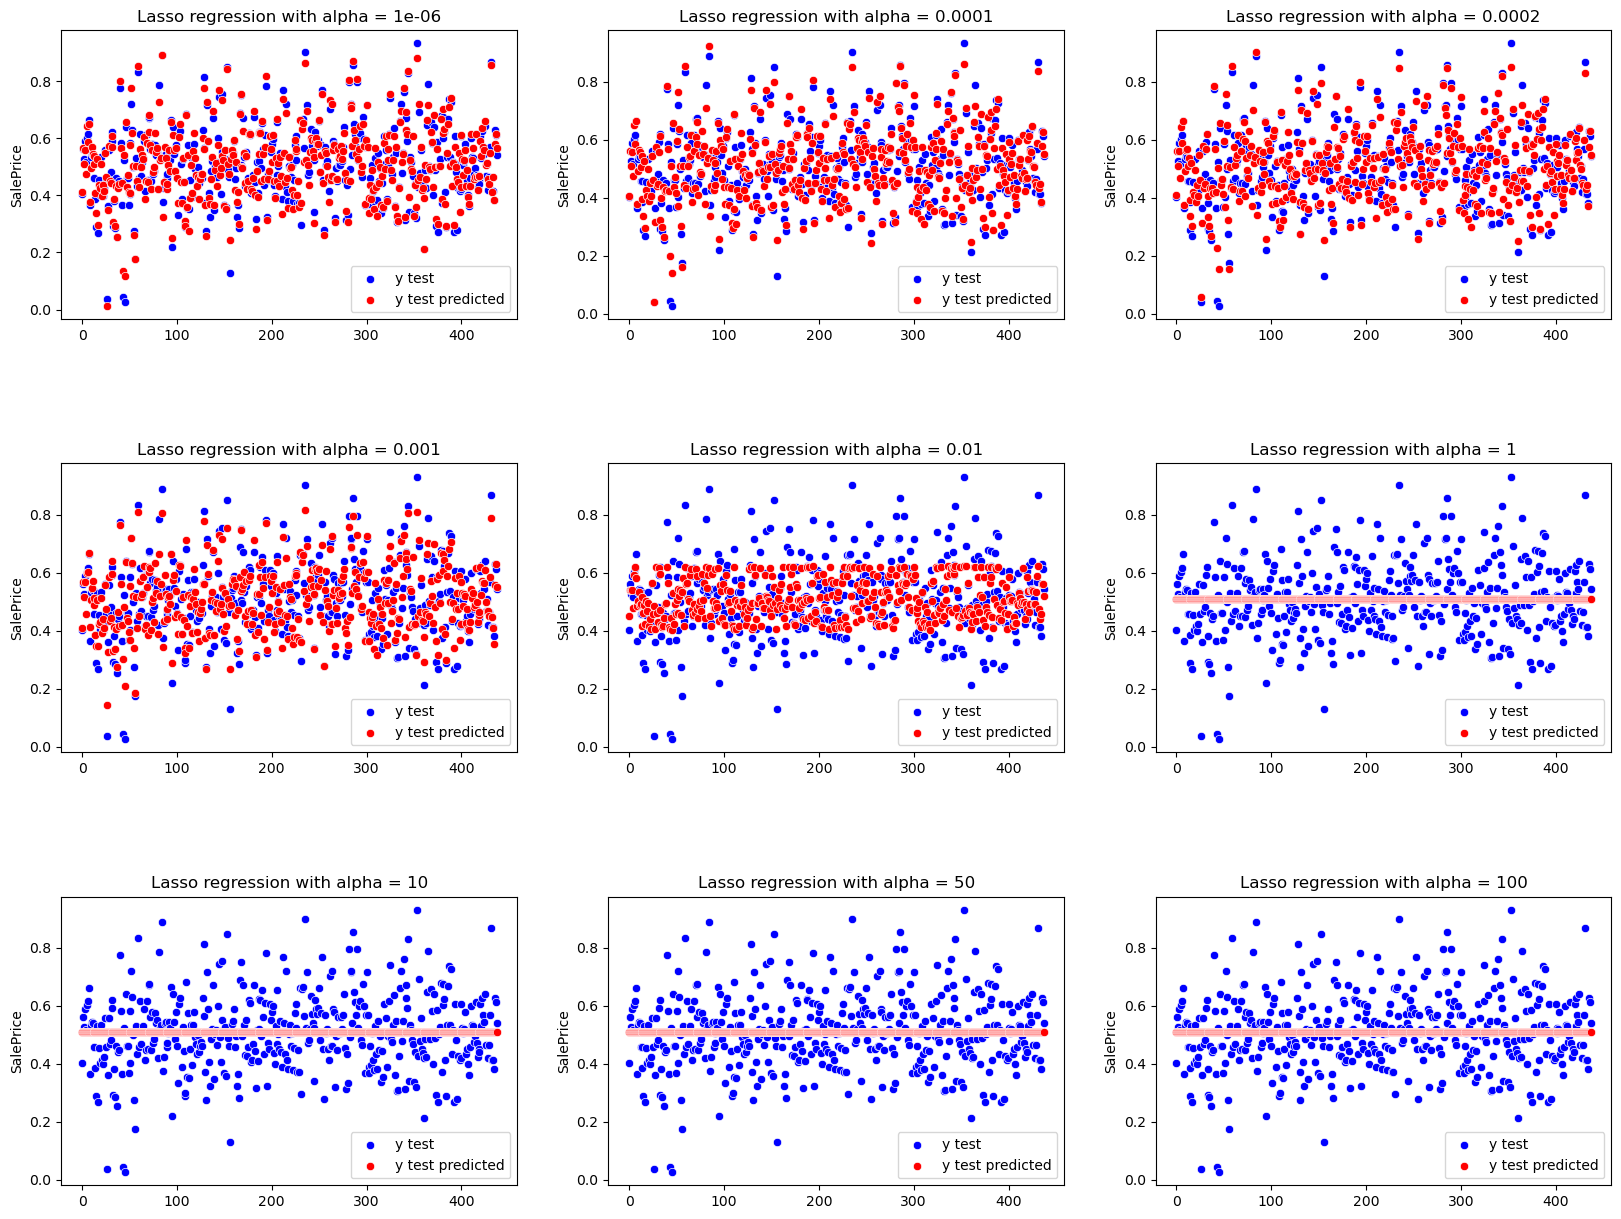

In [271]:
hyperParams=params['alpha']
fig, axis = plt.subplots(3, 3, figsize=(20, 15))
row=0
column=0
for value in hyperParams:
    if column >=3:
        row=row+1
        column=0
        if row == 3:
            break
        
    lasso = Lasso(alpha=value)
    lasso.fit(x_test, y_test)
    sns.scatterplot(x=range(len(y_test)),y=y_test, ax=axis[row,column],color="blue")
    sns.scatterplot(x=range(len(y_test)),y=lasso.predict(x_test), ax=axis[row,column],color="red")
    axis[row,column].set_title(f"Lasso regression with alpha = {value}")
    axis[row,column].legend(['y test','y test predicted'])
    column=column+1  
    
plt.subplots_adjust(hspace=0.5)
plt.show()    

### Interpretation 
- it can be observed that there is not much differernce between the plot of atual target variable and predicted target variable
from alpha .0001 to .001
- aplha from .01 started showing that model has become too simple to cover all the variation and bias has also increased significantly
- Although based on the other parameters such as mean score time, mean fit time etc. alpha .0001 is best


In [272]:
gridSearchStats=pd.DataFrame(model_cv.cv_results_)
gridSearchStats

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.112506,0.025461,0.003983,0.001080,0.000001,{'alpha': 1e-06},-0.032974,-0.032342,-0.033953,-0.031563,...,-0.033021,0.001003,3,-0.024937,-0.021206,-0.022859,-0.025171,-0.024861,-0.023807,0.001543
1,0.023735,0.003591,0.003597,0.000810,0.0001,{'alpha': 0.0001},-0.028629,-0.031058,-0.033382,-0.026534,...,-0.030045,0.002316,1,-0.026146,-0.022789,-0.023630,-0.026462,-0.025965,-0.024998,0.001493
2,0.014953,0.000651,0.002999,0.000014,0.0002,{'alpha': 0.0002},-0.028387,-0.031798,-0.033552,-0.026850,...,-0.030401,0.002432,2,-0.027753,-0.024648,-0.024774,-0.027683,-0.027193,-0.026410,0.001401
3,0.011176,0.001950,0.004188,0.001464,0.001,{'alpha': 0.001},-0.032420,-0.038230,-0.036257,-0.033157,...,-0.035700,0.002507,4,-0.034398,-0.032329,-0.033415,-0.034783,-0.034490,-0.033883,0.000903
4,0.012161,0.002482,0.005385,0.001197,0.01,{'alpha': 0.01},-0.060228,-0.064994,-0.061795,-0.057870,...,-0.062173,0.002996,5,-0.062416,-0.060762,-0.062239,-0.062490,-0.060961,-0.061774,0.000752
5,0.008183,0.000976,0.003591,0.000488,1,{'alpha': 1},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,6,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
6,0.007987,0.000025,0.003389,0.000488,10,{'alpha': 10},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,6,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
7,0.007380,0.000503,0.003391,0.000798,50,{'alpha': 50},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,6,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
8,0.010574,0.002046,0.004984,0.001900,100,{'alpha': 100},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,6,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625


### Observation for GridSearchCv results
- It can be observed in above table that least mean error comes with alpha .0001


###  Lets now directly build model using Lasso with best alpha 

In [273]:
lasso = Lasso(alpha=lassoModelBestParam['alpha'])
lasso.fit(x_train, y_train)
print('Lasso Model Best alpha value',lasso.get_params)
print('Beta Bo ',lasso.intercept_,'\n')

lassoCoeff=np.array(lasso.coef_)
features=list(x_train.columns)
betasAndFeaturesLasso=pd.DataFrame(zip(lassoCoeff,features))
betasAndFeaturesLasso=betasAndFeaturesLasso.rename(columns={0:'beta',1:'features'})
count=betasAndFeaturesLasso[betasAndFeaturesLasso['beta']==0].shape[0] 

print('Count of independent variables (features) whose beta is zero is :',count)
betasAndFeaturesLasso=betasAndFeaturesLasso.sort_values('beta',ascending=False)
betasAndFeaturesLasso

Lasso Model Best alpha value <bound method BaseEstimator.get_params of Lasso(alpha=0.0001)>
Beta Bo  0.08221185291665678 

Count of independent variables (features) whose beta is zero is : 77


,beta,features
14,0.308287,GrLivArea
3,0.162438,OverallQual
4,0.094896,OverallCond
22,0.078638,GarageCars
31,0.056504,MSZoning_RL
...,...,...
52,-0.021060,Neighborhood_MeadowV
51,-0.023857,Neighborhood_IDOTRR
147,-0.024127,BsmtExposure_notavail
49,-0.026774,Neighborhood_Edwards


### Top five independent variables that are contributor to the model are

In [274]:
betasAndFeaturesLasso.head(5)

,beta,features
14,0.308287,GrLivArea
3,0.162438,OverallQual
4,0.094896,OverallCond
22,0.078638,GarageCars
31,0.056504,MSZoning_RL


## Calculating RSS, R2Score , MSE, RMSE for Lasso model

In [275]:
y_pred_train_lasso=lasso.predict(x_train)
y_pred_test_lasso=lasso.predict(x_test)


r2ScoreTrainLasso = r2_score(y_train,y_pred_train_lasso)
r2ScoreTestLasso = r2_score(y_test, y_pred_test_lasso)

rssTrainLasso=np.sum(np.square(y_train-y_pred_train_lasso))
rssTestLasso=np.sum(np.square(y_test-y_pred_test_lasso))

mseTrainLasso = mean_squared_error(y_train, y_pred_train_lasso)
rmseTrainLasso=mseTrainLasso**.5


mseTestLasso = mean_squared_error(y_test, y_pred_test_lasso)
rmseTestLasso=mseTestLasso**.5

lassoRegressionData = {
    'Lasso':{'R2_score Train': r2ScoreTrainLasso, 'R2_score Test': r2ScoreTestLasso, 'RSS Train': rssTrainLasso,
     'RSS Test': rssTestLasso, 'MSE Train': mseTrainLasso, 'MSE Test': mseTestLasso,'RMSE Train': rmseTrainLasso,
                        'RMSE Test': rmseTestLasso}
}


lassoRegressionData = pd.DataFrame.from_dict(lassoRegressionData)
modelPerformanceComparision=pd.concat([modelPerformanceComparision,lassoRegressionData],axis=1)
modelPerformanceComparision


,Linear Regression,Lasso
MSE Test,3.324731e+20,0.001999
MSE Train,1.451160e-03,0.001383
R2_score Test,-1.909659e+22,0.885180
R2_score Train,9.127515e-01,0.916848
RMSE Test,1.823385e+10,0.044710
RMSE Train,3.809409e-02,0.037189
RSS Test,1.456232e+23,0.875573
RSS Train,1.481634e+00,1.412076


#### Inference

- There is not much reduction in the R2 Score from training to test hence there is no overfitting
- RSS error almost become half from traing to test
- Model is able to explain 88% of unseen data
- Model demonstrates a good balance between bias and variance, effectively capturing the underlying trend in the data without being overly tailored to the training set, while there is slight increase in RMSE, MSE


# Verifying Assumptions for Lasso

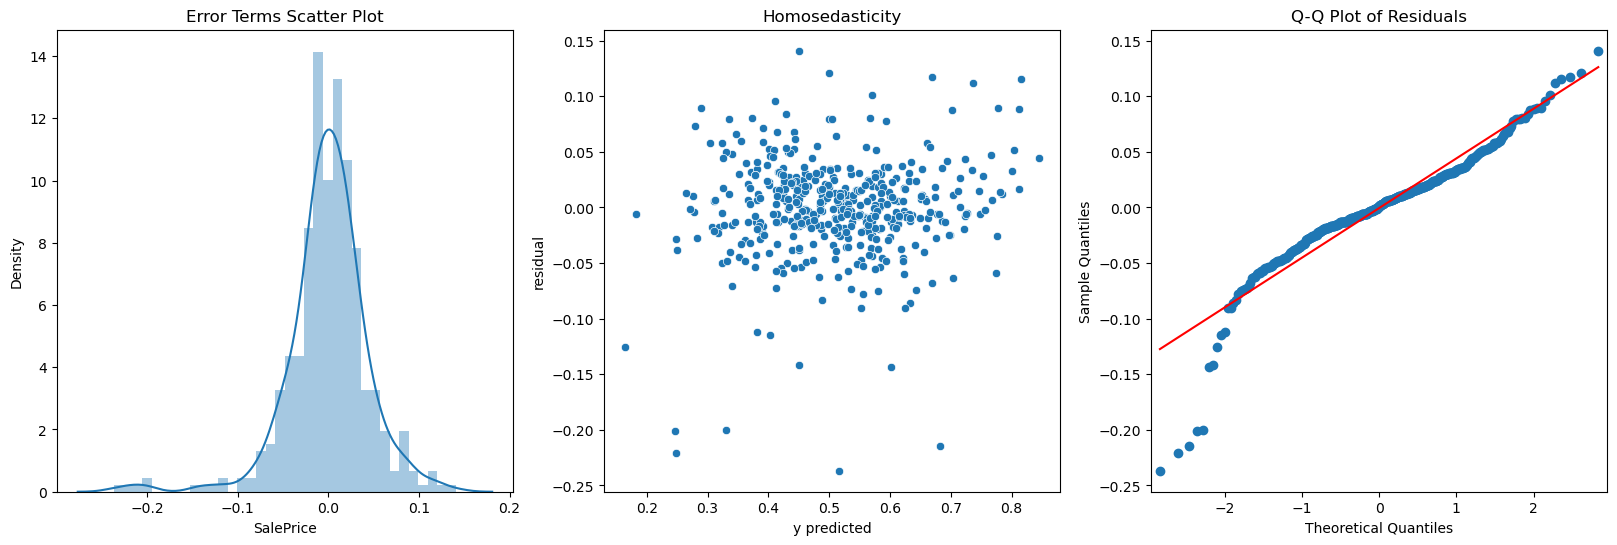

In [276]:
residual=y_test-y_pred_test_lasso

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_pred_test_lasso,y=residual , ax=axis[1])
axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()

### Observation
- Residual are linearly distributed
- Error terms show no pattern and constant variance
- QQ plot also shows linear distribution of error terms

# Ridge

In [277]:
params = {'alpha': [0.000001,0.0001,0.0002, 0.001,1,2,4,10,50,100,250,500]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 
ridgeModelBestParam=model_cv.best_params_
print(ridgeModelBestParam)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'alpha': 2}


In [278]:
gridSearchStats=pd.DataFrame(model_cv.cv_results_)
gridSearchStats

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007580,0.000798,0.003391,4.885394e-04,0.000001,{'alpha': 1e-06},-0.032904,-0.032495,-0.034315,-0.031786,...,-0.033199,0.001049,8,-0.024902,-0.021195,-0.022812,-0.025169,-0.024851,-0.023786,0.001546
1,0.008777,0.001828,0.004589,1.013654e-03,0.0001,{'alpha': 0.0001},-0.032904,-0.032493,-0.034311,-0.031784,...,-0.033197,0.001049,7,-0.024903,-0.021195,-0.022812,-0.025169,-0.024851,-0.023786,0.001546
2,0.007181,0.000746,0.004594,8.098183e-04,0.0002,{'alpha': 0.0002},-0.032904,-0.032491,-0.034308,-0.031782,...,-0.033195,0.001048,6,-0.024903,-0.021195,-0.022811,-0.025169,-0.024851,-0.023786,0.001546
3,0.006590,0.000479,0.003192,3.961183e-04,0.001,{'alpha': 0.001},-0.032904,-0.032476,-0.034283,-0.031765,...,-0.033181,0.001047,5,-0.024905,-0.021197,-0.022809,-0.025168,-0.024851,-0.023786,0.001546
4,0.006384,0.000490,0.003391,4.896679e-04,1,{'alpha': 1},-0.031049,-0.032394,-0.033282,-0.027484,...,-0.031401,0.002095,3,-0.025354,-0.022241,-0.023331,-0.025785,-0.025287,-0.024399,0.001373
5,0.007182,0.001466,0.003589,1.196981e-03,2,{'alpha': 2},-0.030066,-0.032843,-0.033263,-0.027360,...,-0.031258,0.002253,1,-0.025844,-0.023048,-0.023810,-0.026260,-0.025709,-0.024934,0.001265
6,0.006582,0.000489,0.003191,3.989950e-04,4,{'alpha': 4},-0.029189,-0.033424,-0.033626,-0.027310,...,-0.031372,0.002620,2,-0.026695,-0.024237,-0.024674,-0.026938,-0.026422,-0.025793,0.001113
7,0.006583,0.000489,0.003191,3.993528e-04,10,{'alpha': 10},-0.028859,-0.034908,-0.034965,-0.027906,...,-0.032322,0.003231,4,-0.028605,-0.026719,-0.026713,-0.028794,-0.028150,-0.027796,0.000906
8,0.006782,0.000400,0.002991,8.176054e-07,50,{'alpha': 50},-0.033218,-0.041544,-0.039628,-0.034556,...,-0.038079,0.003515,9,-0.036034,-0.034341,-0.034567,-0.036027,-0.034999,-0.035194,0.000715
9,0.007979,0.001792,0.003997,8.937731e-04,100,{'alpha': 100},-0.037023,-0.045039,-0.042679,-0.038466,...,-0.041762,0.003454,10,-0.040421,-0.038724,-0.039170,-0.040297,-0.039222,-0.039567,0.000671


### Plotting scatter plot between y test actual and y test pred with different alpha

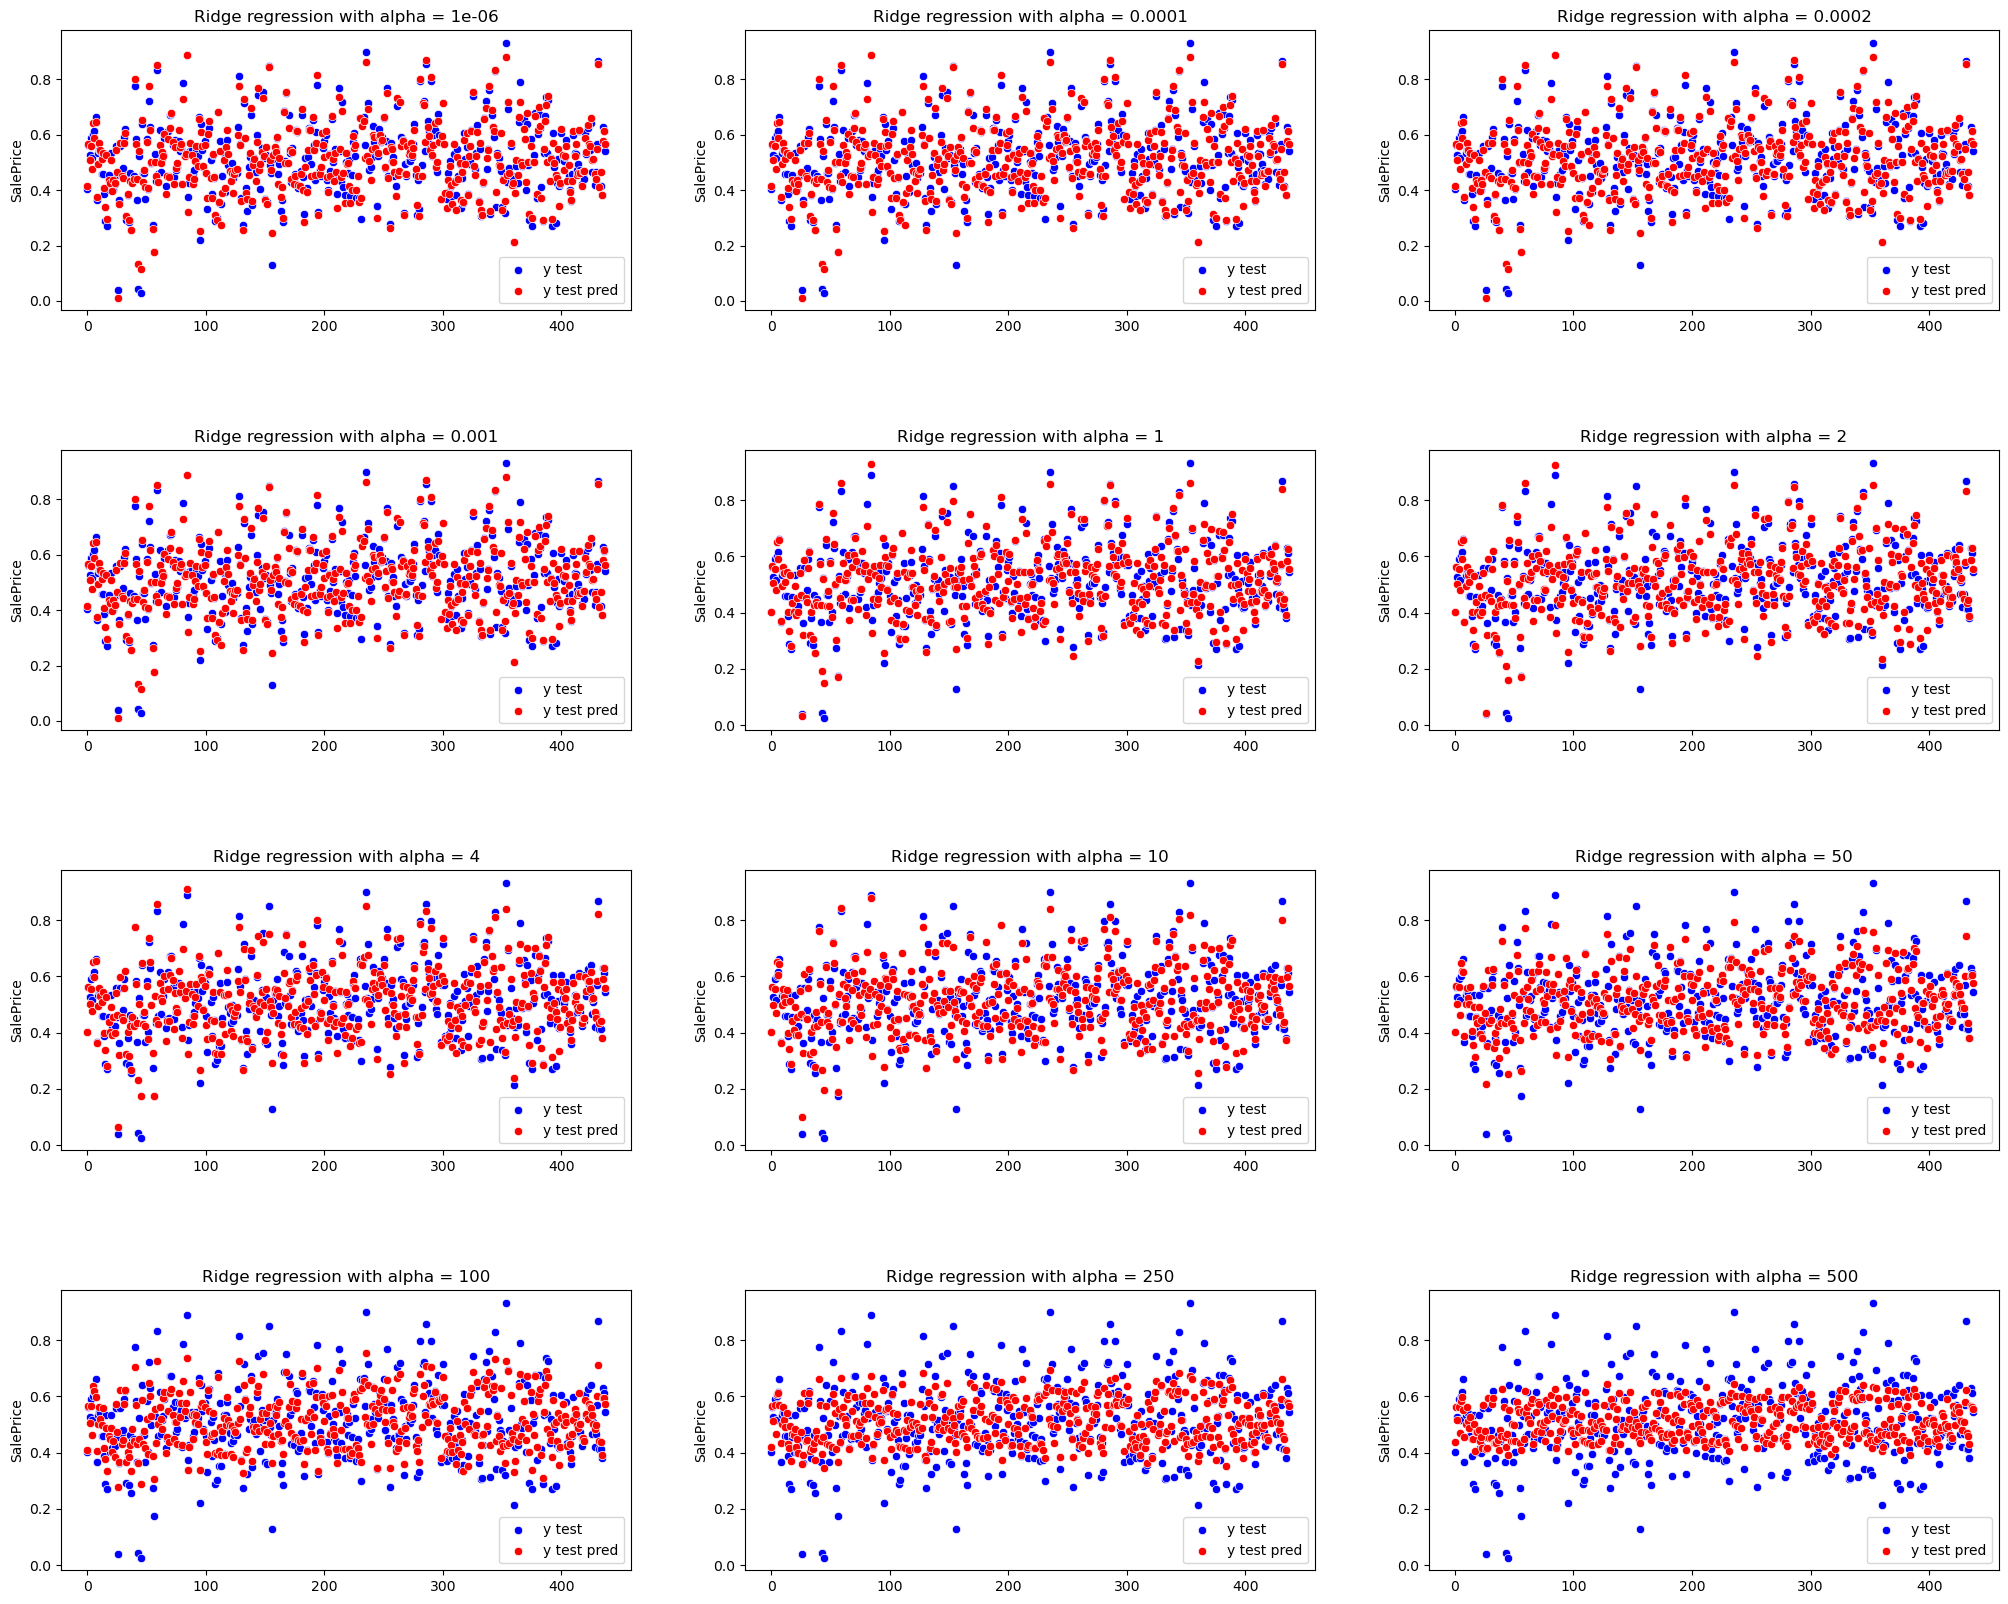

In [279]:
alphaParams=params['alpha']
fig, axis = plt.subplots(4, 3, figsize=(25, 20))
row=0
column=0
for value in alphaParams:
    if column >=3:
        row=row+1
        column=0
        if row == 4:
            break
        
    ridge = Ridge(alpha=value)
    ridge.fit(x_test, y_test)
    sns.scatterplot(x=range(len(y_test)),y=y_test, ax=axis[row,column],color="blue")
    sns.scatterplot(x=range(len(y_test)),y=ridge.predict(x_test), ax=axis[row,column],color="red")
    axis[row,column].set_title(f"Ridge regression with alpha = {value}")
    axis[row,column].legend(['y test','y test pred'])

    column=column+1  
    
plt.subplots_adjust(hspace=0.5)
plt.show()    

### Observation 

- It can be observed that there is not much differernce between the plot of atual target variable and predicted target variable
from alpha .0001 to 10.

    ##### <b> Reason for significant variation in alpha</b>
    
    - The reason for observing a significant variation in alpha to observe a significant reduction in model performance, could be due to the dataset containing many features, some of which may not be highly relevant. By increasing alpha, Ridge regression reduces the magnitude of coefficients associated with less important features, which can help in reducing model variance without substantially increasing bias. However, it's important to note that while the coefficients for less relevant features are reduced, they are not set to zero.
    - with increase of alpha r2 score and other parameter also changes, out of these parameters alpha 2 is the best
    
#### Note
##### This observation is different because Lasso makes beta coefficient zero for feature selection


In [280]:
ridge = Ridge(alpha=ridgeModelBestParam['alpha'])

ridge.fit(x_train, y_train)
print('Ridge Best alpha value',ridge.get_params)
print('Beta βo ',ridge.intercept_,'\n')
print('Features and Beta Coefficients')

betaAndCoff=pd.DataFrame(zip(x_train.columns,ridge.coef_))
betaAndCoff=betaAndCoff.rename(columns={0:'features',1:'beta'})
betaAndCoff.sort_values('beta',ascending=False)

Ridge Best alpha value <bound method BaseEstimator.get_params of Ridge(alpha=2)>
Beta βo  0.12498451745924394 

Features and Beta Coefficients


,features,beta
3,OverallQual,0.128202
14,GrLivArea,0.095476
12,1stFlrSF,0.083750
4,OverallCond,0.079901
13,2ndFlrSF,0.063707
...,...,...
169,FireplaceQu_Po,-0.026021
0,MSSubClass,-0.028297
49,Neighborhood_Edwards,-0.029826
51,Neighborhood_IDOTRR,-0.034125


In [281]:
y_pred_train_ridge=ridge.predict(x_train)
y_pred_test_ridge=ridge.predict(x_test)


r2ScoreTrainRidge = r2_score(y_train,y_pred_train_ridge)
r2ScoreTestRidge = r2_score(y_test, y_pred_test_ridge)

rssTrainRidge=np.sum(np.square(y_train-y_pred_train_ridge))
rssTestRidge=np.sum(np.square(y_test-y_pred_test_ridge))

mseTrainRidge = mean_squared_error(y_train, y_pred_train_ridge)
rmseTrainRidge=mseTrainRidge**.5


mseTestRidge = mean_squared_error(y_test, y_pred_test_ridge)
rmseTestRidge=mseTestRidge**.5

ridgeRegressionData = {
    'Ridge':{'R2_score Train': r2ScoreTrainRidge, 'R2_score Test': r2ScoreTestRidge, 'RSS Train': rssTrainRidge,
     'RSS Test': rssTestRidge, 'MSE Train': mseTrainRidge, 'MSE Test': mseTestRidge,'RMSE Train': rmseTrainRidge,
                        'RMSE Test': rmseTestRidge}
}


ridgeRegressionData = pd.DataFrame.from_dict(ridgeRegressionData)
modelPerformanceComparision=pd.concat([modelPerformanceComparision,ridgeRegressionData],axis=1)
modelPerformanceComparision

,Linear Regression,Lasso,Ridge
MSE Test,3.324731e+20,0.001999,0.002110
MSE Train,1.451160e-03,0.001383,0.001325
R2_score Test,-1.909659e+22,0.885180,0.878812
R2_score Train,9.127515e-01,0.916848,0.920344
RMSE Test,1.823385e+10,0.044710,0.045934
RMSE Train,3.809409e-02,0.037189,0.036399
RSS Test,1.456232e+23,0.875573,0.924136
RSS Train,1.481634e+00,1.412076,1.352706


## Inference
- Among the three models, the Lasso regression emerges as the superior choice, demonstrated by its minimal Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), along with the highest R-squared (R2_score) values for both training and testing data. This suggests Lasso regression offers the most precise predictions and effectively captures the data's variability. The Linear Regression model falls short, especially evident from its negative R2_score on the testing dataset, whereas the Ridge model shows commendable performance but is marginally surpassed by Lasso.

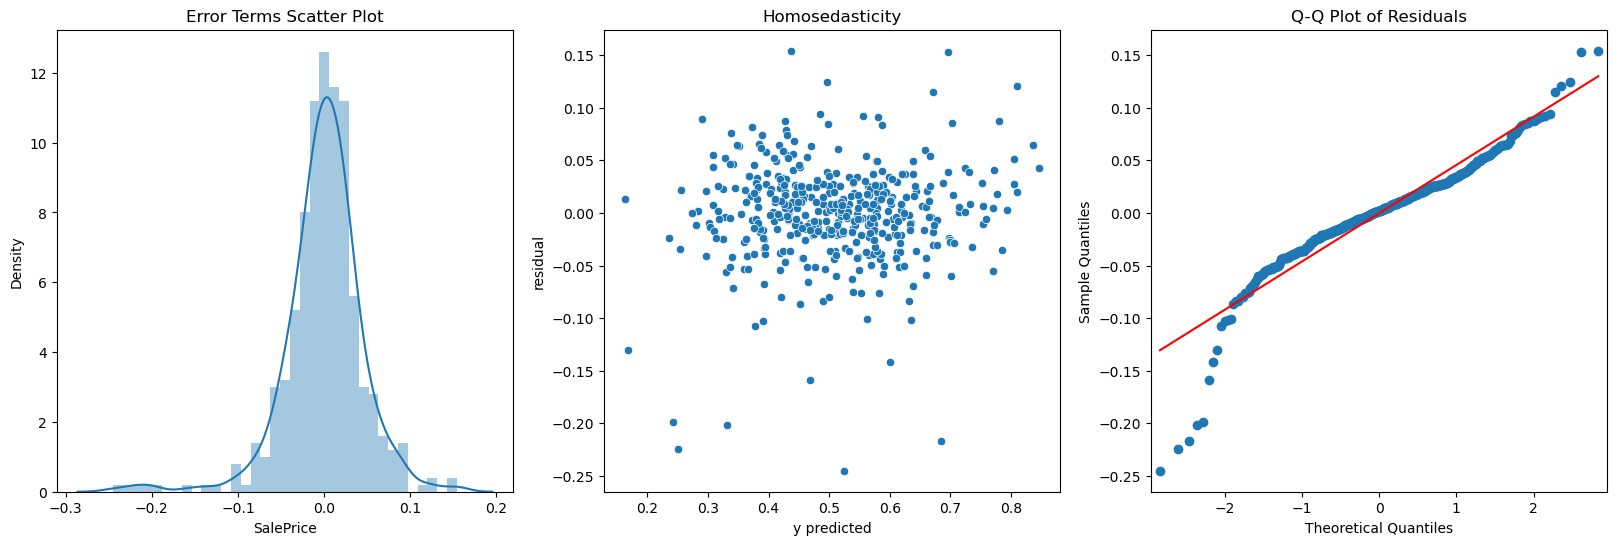

In [282]:
residual=y_test-y_pred_test_ridge

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_pred_test_ridge,y=residual , ax=axis[1])


axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")
import scipy.stats as stats

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()

### Observation
- Residual are linearly distributed
- error terms show no pattern and constant variance
- QQ plot also shows linear distribution of error terms